In [81]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import sys
sys.path.append('python')

In [83]:
from utils import (
    show_images,
    save_model_weights,
    load_model_weights,
    submission_generate_images,
    seed_everything,
    get_device,
    count_parameters,
    show_generate_imgs
)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm_notebook
import os
import numpy as np
import matplotlib.pyplot as plt

from dataset import MotorbikeDataset, get_transforms
from layers import init_weight, conv1x1, conv3x3, Attention, ConditionalNorm

In [84]:
import os
import sys
from client.mifid_demo import MIFID
from glob import glob
import numpy as np
import cv2
from PIL import Image
from tqdm import tqdm_notebook
import shutil

In [85]:
mifid = MIFID(model_path='./client/motorbike_classification_inception_net_128_v4_e36.pb', 
public_feature_path='./client/public_feature.npz')

[Motorbike Classifer] Load Motorbike Classifer from ./client/motorbike_classification_inception_net_128_v4_e36.pb
Load Public Embedding Features


In [86]:
import glob

result_image = glob.glob('result_20191025v3/*.*')

In [87]:
indicates = list(range(len(result_image)))
np.random.shuffle(indicates)
sample_paths = [result_image[i] for i in indicates[:10]]

In [101]:
import cv2

def load_image(path, denoising=False, sharpen=False):
    im = cv2.imread(path, cv2.IMREAD_COLOR)
    im = cv2.resize(im, (128, 128))

    if sharpen:
        # Create our shapening kernel, it must equal to one eventually
        kernel_sharpening = np.array([[-1,-1,-1], 
                                      [-1, 9,-1],
                                      [-1,-1,-1]])
        # applying the sharpening kernel to the input image & displaying it.
        im = cv2.filter2D(im, -1, kernel_sharpening)
        
    if denoising:
        im = cv2.fastNlMeansDenoisingColored(im,None,10,10,7,21)   

    return im

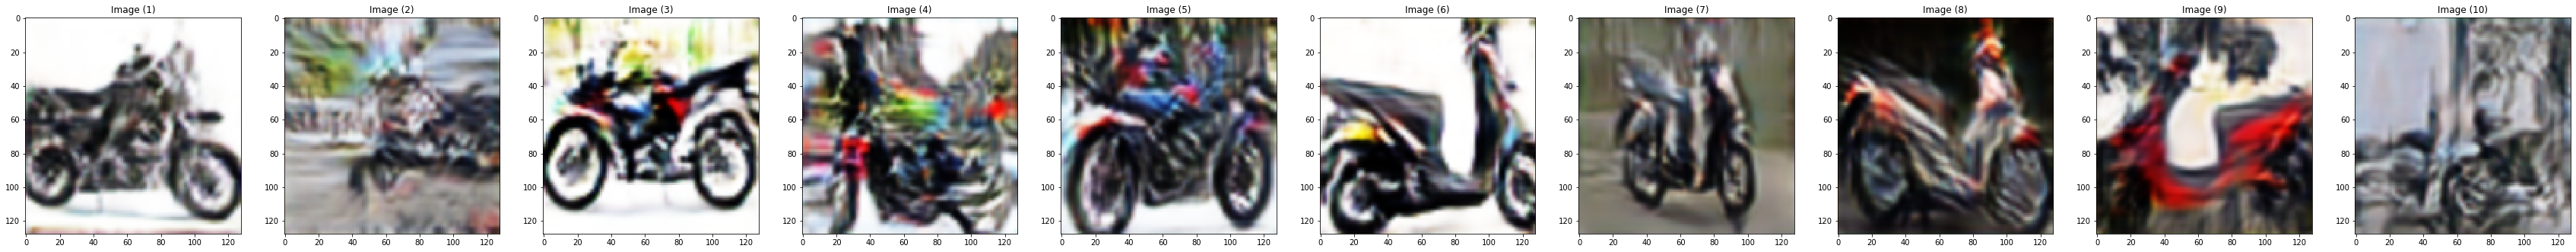

In [102]:
list_img = [load_image(i) for i in sample_paths]
show_images(list_img, cols=1)

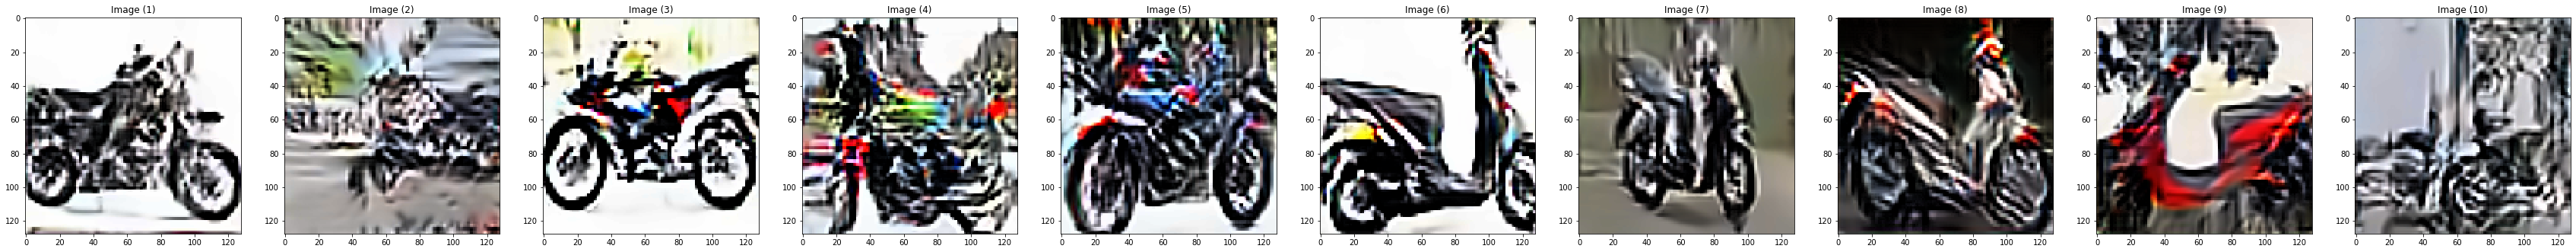

In [103]:
list_img = [load_image(i, denoising=True, sharpen=True) for i in sample_paths]
show_images(list_img, cols=1)

In [104]:
def get_score(img_paths, post_process_fnc=None):
    img_np = np.empty((len(img_paths), 128, 128, 3), dtype=np.uint8)
    for idx, path in tqdm_notebook(enumerate(img_paths), total=len(img_paths)):
        img_arr = post_process_fnc(path)
        img_arr = img_arr[..., ::-1]
        img_arr = np.array(img_arr)
        img_np[idx] = img_arr

    score = mifid.compute_mifid(img_np)
    return score

In [105]:
f1 = partial(load_image, denoising = True, sharpen=False)
get_score(result_image, f1)

  0%|          | 0/313 [00:00<?, ?it/s]


Compute embedding features ...
------------------------------------------------------


100%|██████████| 313/313 [09:01<00:00,  1.73s/it]


done
------------------------------------------------------
m1, m2 shape = (2048,), (2048,)
s1, s2 shape = (2048, 2048), (2048, 2048)

Starting calculating FID
- Compute sqrtm in 5.285006999969482
covmean.shape=(2048, 2048)
- Compute trace in 0.0020961761474609375
Done with FID, starting distance calculation
rows of zeros in features1 = 0
rows of zeros in features2 = 0
d.shape= (10000, 10373)
np.min(d, axis=1).shape=(10000,)
distance=0.29747396185160035
Compute distance with threshold=0.05

FID: 164.88501853784305
distance: 1
Final Score: 164.8850185378414


164.8850185378414

In [100]:
f1 = partial(load_image, denoising = True, sharpen=True)
get_score(result_image, f1)

KeyboardInterrupt: 

In [94]:
f1 = partial(load_image, denoising = False, sharpen=False)
get_score(result_image, f1)

  0%|          | 0/313 [00:00<?, ?it/s]


Compute embedding features ...
------------------------------------------------------


100%|██████████| 313/313 [09:40<00:00,  1.85s/it]


done
------------------------------------------------------
m1, m2 shape = (2048,), (2048,)
s1, s2 shape = (2048, 2048), (2048, 2048)

Starting calculating FID
- Compute sqrtm in 4.827118158340454
covmean.shape=(2048, 2048)
- Compute trace in 0.00026297569274902344
Done with FID, starting distance calculation
rows of zeros in features1 = 0
rows of zeros in features2 = 0
d.shape= (10000, 10373)
np.min(d, axis=1).shape=(10000,)
distance=0.30093198917806524
Compute distance with threshold=0.05

FID: 163.52909586729845
distance: 1
Final Score: 163.52909586729683


163.52909586729683